This notebook was automatically tested on the EOTDL platform with kernel **eotdl-1-2023.10**
<details>
    
```
    channels:
    - conda-forge
    dependencies:
    - python=3.10
    - ipykernel
    - geojson
    - ipyleaflet
    - ipywidgets<8.0.0
    - jupyterlab_widgets<2.0.0
    - jupyterlab-geojson
    - libgcc
    - libpng
    - papermill
    - timm
    - geomet
    - matplotlib
    - lightning
    - rioxarray
    - pystac
    - pyproj
    - mlflow
    - pip:
      - pytorch-eo==2023.7.21
      - eotdl==2023.9.14.post4
    description: ''
    name: eotdl-1-2023.10
    prefix: null

```
</details>

# Training with S2 images using SEN12-FLOOD dataset (MLFlow)

In this use case, we are going to train an image classifiers with Sentinel-2 images using the SEN12-FLOOD dataset. For a training run with Sentinel-1 images please check the related [tutorial notebooks](https://notebooks.api.eotdl.com/?search=SEN12-FLOOD)!

In [1]:
import os
from pathlib import Path
path = Path(os.environ.get('EOTDL_DOWNLOAD_PATH'), 'SEN12-FLOOD')
assert(path.exists) 

> ***Note:*** the hosted [EOTDL](https://eotdl.com) platform ensures that onboarded training datasets are readily available, to access the datasets from your local machine or other platforms please check the corresponding [tutorial notebooks](https://notebooks.api.eotdl.com/?search=offline)!

In [2]:
from pytorch_eo.datasets import SEN12Floods
from pytorch_eo.datasets.sensors import Sensors, S1, S2

import lightning as L
from sklearn.metrics import average_precision_score
import albumentations as A
from pytorch_eo.tasks.classification import ImageClassification
import timm
import torch

/home/conda/users/83063087050d2631bcd8fb823655f6e0242d491790c74fc498aabcb0346d0272-20230925-204049-809427-13-eotdl-1-2023.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/conda/users/83063087050d2631bcd8fb823655f6e0242d491790c74fc498aabcb0346d0272-20230925-204049-809427-13-eotdl-1-2023.10/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
import mlflow

> ***Note:*** for experiment tracking this example will use MLFlow. You can e.g. start the MLFlow server on port 3003 and inspect the training progress via `https://<your-jupyterhub-url>/user/<username>/proxy/3003/`

In [4]:
# !mlflow server -p 3003

## Sentinel-2

In [5]:
ds = SEN12Floods(processed_data_path=path,
                 batch_size=25,
                 verbose=True 
                ) 

ds.setup()

Training samples 1342
Validation samples 447
Test samples 447


As showed before, all out datasets have a `DataFrame` containing the required data to train the model.

In [6]:
ds.df

,image,label
0,/cache/datasets/SEN12-FLOOD/sen12floods_s2_sou...,0
1,/cache/datasets/SEN12-FLOOD/sen12floods_s2_sou...,0
2,/cache/datasets/SEN12-FLOOD/sen12floods_s2_sou...,0
3,/cache/datasets/SEN12-FLOOD/sen12floods_s2_sou...,0
4,/cache/datasets/SEN12-FLOOD/sen12floods_s2_sou...,0
...,...,...
2231,/cache/datasets/SEN12-FLOOD/sen12floods_s2_sou...,0
2232,/cache/datasets/SEN12-FLOOD/sen12floods_s2_sou...,0
2233,/cache/datasets/SEN12-FLOOD/sen12floods_s2_sou...,0
2234,/cache/datasets/SEN12-FLOOD/sen12floods_s2_sou...,0


In [7]:
ds.num_classes, ds.classes

(2, ['NO_FLOODING', 'FLOODING'])

Let's visualize some samples from the dataset. 

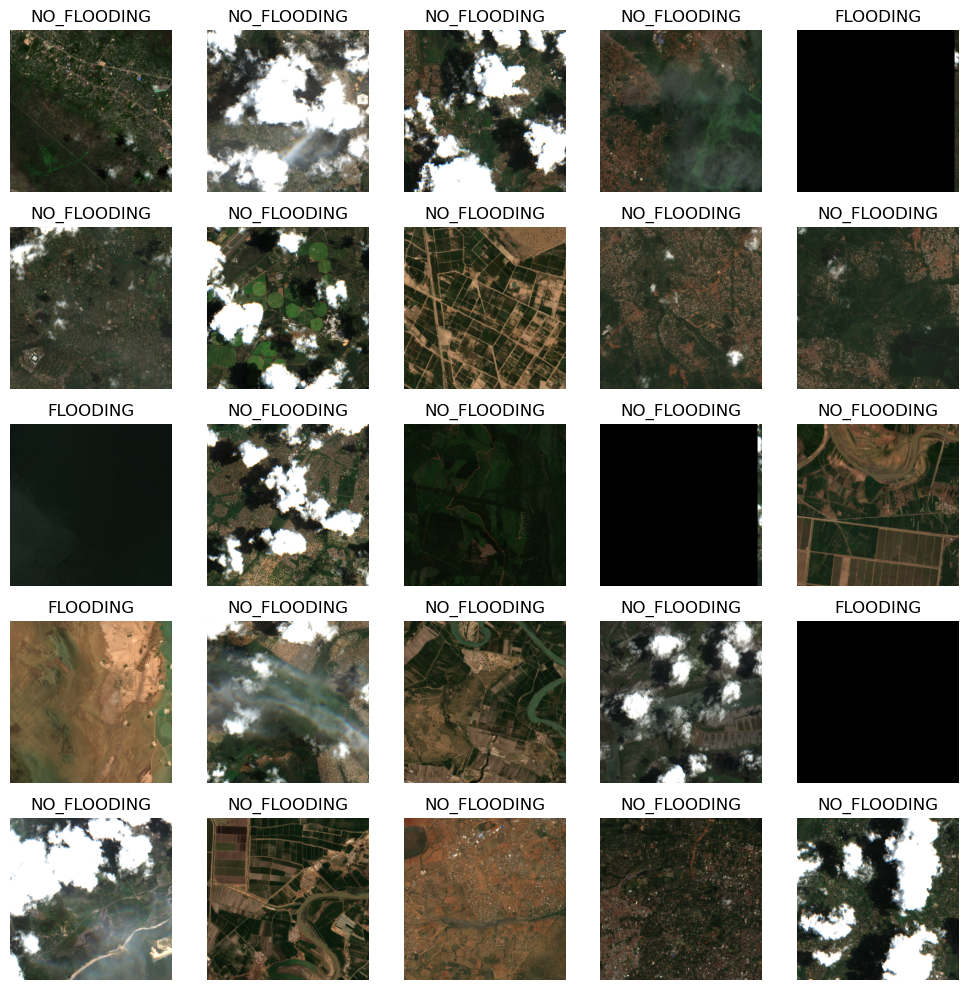

In [8]:
import matplotlib.pyplot as plt

# extract a batch of samples (you can also access val_dataloader or test_dataloader for the other splits)

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train an image classifier on this dataset. To do so, we need to define a `task`. In this case, we use the `ImageClassification` task.

In [9]:
import torch 
from pytorch_eo.tasks.classification import ImageClassification

task = ImageClassification(num_classes=ds.num_classes)

output = task(torch.randn(8, 3, 224, 224))
output.shape

torch.Size([8, 2])

Now, we can use `Pytorch Lightning` for solving the `task` on the given `dataset`.

In [10]:
import lightning as L
import mlflow
from lightning.pytorch.loggers import MLFlowLogger

trainer = L.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    max_epochs=2,
    logger = MLFlowLogger(experiment_name="SEN12-FLOOD_s2")
)

trainer.fit(task, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training samples 1342
Validation samples 447
Test samples 447


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | ResNet             | 11.2 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/conda/users/83063087050d2631bcd8fb823655f6e0242d491790c74fc498aabcb0346d0272-20230925-204049-809427-13-eotdl-1-2023.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/conda/users/83063087050d2631bcd8fb823655f6e0242d491790c74fc498aabcb0346d0272-20230925-204049-809427-13-eotdl-1-2023.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_wa

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Once the model is trained, we can evaluate it on the test set to compute the final metrics.

In [11]:
trainer.test(dataloaders=ds.test_dataloader())

/home/conda/users/83063087050d2631bcd8fb823655f6e0242d491790c74fc498aabcb0346d0272-20230925-204049-809427-13-eotdl-1-2023.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at ./mlruns/798832182647506881/7d31ccdabd0e4f60abf75117e3c10c12/checkpoints/epoch=1-step=108.ckpt


Training samples 1342
Validation samples 447
Test samples 447


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/798832182647506881/7d31ccdabd0e4f60abf75117e3c10c12/checkpoints/epoch=1-step=108.ckpt
/home/conda/users/83063087050d2631bcd8fb823655f6e0242d491790c74fc498aabcb0346d0272-20230925-204049-809427-13-eotdl-1-2023.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8098434209823608     │
│         test_loss         │    0.40369072556495667    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.40369072556495667, 'test_acc': 0.8098434209823608}]

And also use it to predict labels on new images.

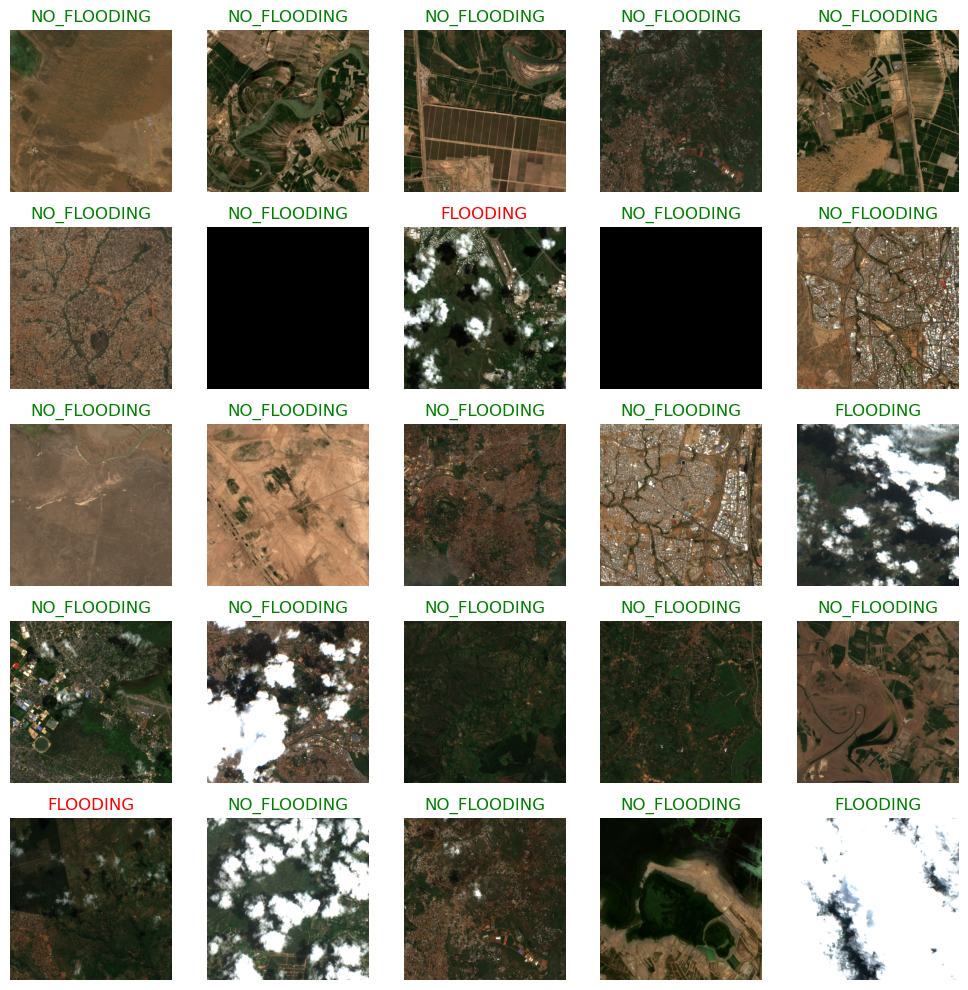

In [12]:
import matplotlib.pyplot as plt

# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img.permute(1,2,0))
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()